# Multiple time series modeling with state space GPs using Numpyro

In this notebook I will implement a state space Gaussian process model for time series using Numpyro. For theoretical background on state space GPs, see my master's [thesis](https://helda.helsinki.fi/bitstreams/d184c917-11a5-456a-8939-fc413e0cb57b/download).

Other sources: <br>
Hartikainen & Särkkä [paper](https://users.aalto.fi/~ssarkka/pub/gp-ts-kfrts.pdf) from 2010. <br>
Solin & Särkkä [paper](https://proceedings.mlr.press/v33/solin14.html) on periodic GPs. <br>
Särkkä & Solin SDE [book](https://users.aalto.fi/~asolin/sde-book/sde-book.pdf). <br>
Yunus Saatçi [dissertation](https://mlg.eng.cam.ac.uk/pub/pdf/Saa11.pdf), especially chapter 2. <br>

This notebook was inspired by https://github.com/mikekeith52/scalecast-examples/blob/main/multivariate/multivariate.ipynb

In [1]:
import pandas as pd
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import numpy as np
import math
import datetime
import jax
import seaborn as sns
from jax import vmap
import jax.numpy as jnp
from jax.scipy.linalg import block_diag, expm
import jax.random as random

from numpyro.handlers import scope, plate
import numpyro
import numpyro.distributions as dist
from numpyro.contrib.control_flow import scan
from numpyro.infer import Predictive, SVI, Trace_ELBO, autoguide, TraceMeanField_ELBO
from numpyro.infer import (
    MCMC,
    NUTS,
    init_to_median,
    init_to_sample,
    TraceEnum_ELBO
)

numpyro.set_host_device_count(4)
numpyro.enable_x64()

In [2]:
# read data
data = pd.read_csv('avocado.csv',parse_dates=['Date']).sort_values(['Date'])
# sort appropriately (not doing this could cause issues)
data = data.sort_values(['region','type','Date'])

# Convert date column to datetime objects
data['Date'] = pd.to_datetime(data['Date'])
# Create column for week number
data['week_no'] = data['Date'].apply(lambda x: datetime.datetime.isocalendar(x)[1]-1)
# Choose data from California
data_cali = data.loc[data['region'] == 'California']
# Separate conventional and organic
data_cali_org = data_cali.loc[data_cali['type'] == 'organic']
data_cali_con = data_cali.loc[data_cali['type'] == 'conventional']


### Plot Data

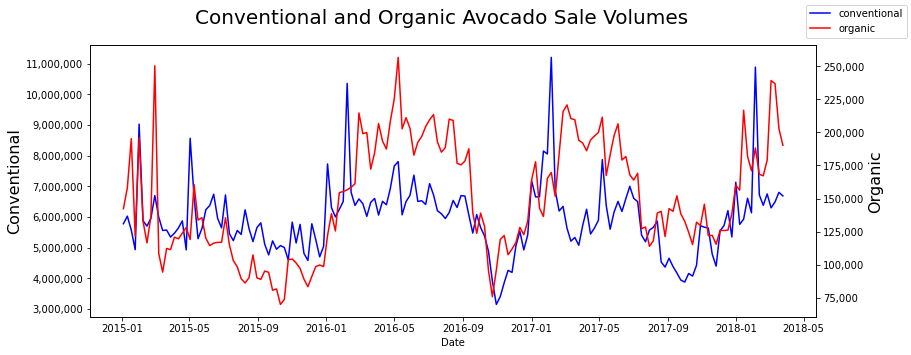

In [3]:
fig, ax = plt.subplots(figsize=(13,5))
sns.lineplot(
    x='Date',
    y='Total Volume',
    data=data_cali_con,
    label='conventional',
    ax=ax,
    color='blue',
    legend=False
)
plt.ylabel('Conventional',size=16)
ax2 = ax.twinx()
sns.lineplot(
    x='Date',
    y='Total Volume',
    data=data_cali_org,
    label='organic',
    ax=ax2,
    color='red',
    legend=False
)
ax.figure.legend()
plt.ylabel('Organic',size=16)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.suptitle('Conventional and Organic Avocado Sale Volumes',size=20)
plt.show()


### Functions for creating state space model matrices


In [4]:
def Fmatern(ell, D):
    """Feedback matrix F corresponding to 
    a GP defined by a Matérn-type covariance function
    with ν=D-1/2 and length-scale ell.
    """
    F = jnp.eye(D,k=1)
    lmda = np.sqrt(2*D-1)/ell
    for j in range(D):
        F = F.at[D-1,j].set(-math.comb(D,j)*lmda**(D-j))
    return F

def Pmatern(F):
    """Steady state covariance matrix P corresponding
    to feedback matrix F of a Matérn GP.
    """
    D = F.shape[0]
    lmda = -F[D-1,D-1]/D
    q = (2*lmda)**(2*D-1) / math.comb(2*D-2,D-1)
    Fkron_sum = jnp.kron(jnp.eye(D),F) + jnp.kron(F, jnp.eye(D))
    P = jnp.linalg.solve(Fkron_sum, jnp.hstack((jnp.zeros(D*D-1),-q)))
    return jnp.reshape(P,(D,D), order = 'F')

def Fperiod(J, per):
    """Feedback matrix F of a periodic
    GP with a covariance function
    defined by a sum of J cosines.
    """
    omega = 2*np.pi/per
    F = jnp.zeros((J*2,J*2))
    for i in range(J):
        F=F.at[2*i+1,2*i].set(omega*(i+1))
        F=F.at[2*i,2*i+1].set(-omega*(i+1))
    return F

def Pperiod(J, ell):
    """Initial state covariance matrix of 
    a periodic kernel based on sum of J cosines.
    """
    v = jnp.zeros(J)
    for j in range(J):
        n = (J-j-1)//2
        for i in range(n+1):
            v = v.at[j].add((2*ell**2)**(-j-1-2*i)/(math.factorial(i+j+1)*math.factorial(i))) 
    P = jnp.diag(jnp.repeat(v,2))
    return 2*P/jnp.exp(ell**(-2))

def QIntWiener(dt, D):
    """Prediction step covariance matrix Q 
    of a (D-1)-times integrated Wiener process.
    """
    F = np.eye(D,k=1)
    A = np.zeros((D,D))
    Im = np.zeros((D,D))
    P = 2*D-1
    for k in range(D):
        A += np.linalg.matrix_power(F,k)*(dt**k)/math.factorial(k)
        for j in range(D):
            Im[k,j] = dt/(P-(k+j))
    L = np.append(np.zeros(D-1),1)
    ALLA = np.outer((A@L),(A@L))
    return Im*ALLA


### Horseshoe prior for week effect
I included this in the notebook for those curious to try. Using the horseshoe prior will make sampling much slower. In my model function I chose to use independent Laplacian priors for the week effects. 

In [5]:
def week_effect(weekdays):
    # weeks: array containing week number (0-52) of observed data
    slab_df = 50  
    slab_scale = 2
    scale_global = 0.1
    tau = numpyro.sample("tau", dist.HalfNormal(2 * scale_global))
    c_aux = numpyro.sample("c_aux", dist.InverseGamma(0.5 * slab_df, 0.5 * slab_df))
    c = slab_scale * jnp.sqrt(c_aux)

    with plate("plate_week_of_year", 53):
        lam = numpyro.sample("lam", dist.HalfCauchy(scale=1))
        lam_tilde = jnp.sqrt(c) * lam / jnp.sqrt(c + (tau * lam) ** 2)
        beta = numpyro.sample("beta", dist.Normal(loc=0, scale=tau * lam_tilde))

    return beta[weekdays]

### "Add GP element to model" -functions
These functions are supposed to be called from inside the model function using the 'scope' effect handler (https://num.pyro.ai/en/stable/handlers.html#scope). They return the feedback, initial covariance and observation model matrices of a Matérn GP and quasi periodic GP. An inverse Gamma prior for the GP marginal variance parameter $\alpha$ improves sampling compared with distributions (e.g. half normal or exponential) that put significant weight on near zero values.

In [6]:
def matern_gp(D,mu,sigma):
    """mu, sigma: mean & std of lognormal prior of length scale.
    D: dimension of feedback matrix. D=ν+1/2.
    """
    alpha = numpyro.sample("alpha", dist.InverseGamma(3.0,2.0))
    length = numpyro.sample("length", dist.LogNormal(mu, sigma))
    F = Fmatern(length, D)
    P = alpha*Pmatern(F)
    H = jnp.hstack((jnp.ones((1,1)),jnp.zeros((1,D-1))))
    return F, P, H

def quasi_period_gp(J,per,mqp,sqp):
    """int J: n of cosines summed in periodic covariance.
    per: length of period.
    mqp, sqp: mean & std of lognormal prior of quasi periodic
    length scale.
    """
    alpha = numpyro.sample("alpha", dist.InverseGamma(3.0,2.0))
    length = numpyro.sample("len_per", dist.LogNormal(2.0,1.0))
    len_qp = numpyro.sample("len_qp", dist.LogNormal(mqp,sqp))
    F = Fperiod(J,per) - 1/len_qp*jnp.eye(2*J)
    P = alpha*Pperiod(J,length)
    H = np.tile([[1,0]],J)
    return F, P, H

def polynomial_gp(D):
    """Fits a polynomial of degree D.
    """
    alpha = numpyro.sample("alpha", dist.InverseGamma(3.0,2.0))
    sigma = numpyro.sample("sigma", dist.InverseGamma(3.0,2.0))
    v = jnp.power(sigma, jnp.arange(D+1))
    P = alpha*jnp.outer(v,v)
    F = jnp.eye(D+1,k=1)
    H = jnp.hstack((jnp.ones((1,1)),jnp.zeros((1,D))))
    return F,P,H

### Kalman Filter and smoother functions
These are written to be used with the 'scan' primitive of Numpyro. This implementation assumes equal time steps, i.e. matrices $A=$exp$(dtF)$ and $Q$ are same for every iteration. The filter returns the vectors and matrices needed for smoothing. The outcommented lines compute the smoothed state covariances P for which I have no use in this notebook.

In [7]:
def Kfilter(carry, xs):
    m, P, A, Q, H, σ = carry
    y, obs = xs
    m = A@m
    P = A@P@A.T + Q
    Ht = jnp.diag(obs)@H
    S = Ht@P@Ht.T + jnp.diag(obs*σ + ~obs)
    K = jnp.linalg.solve(S,Ht@P).T
    L = jnp.eye(P.shape[0]) - K@Ht
    v = (y - Ht@m)*obs
    mt = m + K@v
    Pt = L@P
    L = A@L
    numpyro.sample("v", dist.MultivariateNormal(0,covariance_matrix=S), obs=v)
    numpyro.factor("missing", 0.5*jnp.sum(~obs)*jnp.log(2*jnp.pi)) 
    return (mt,Pt,A,Q,H,σ), (m,P,L,S,v)

def state_smoother(carry, xs):
    r, N, H, Hblk = carry
    m, P, L, S, v = xs
    invSH = jnp.linalg.solve(S,H)
    r = invSH.T@v + L.T@r
    msmooth = m + P@r
    #N = L.T@N@L + H.T@invSH
    #Psmooth = P - P@N@P
    return (r, N, H, Hblk), (H@msmooth, Hblk@msmooth)


### Model function
Model is represented by the equation:
$$
\mathbf{y}(t) =  \boldsymbol{f}_{\text{trend GP}}(t) +\boldsymbol{f}_{\text{quasip. GP}}(t) + \boldsymbol{\beta}_{\text{week}}(t) + \boldsymbol{\varepsilon}_t.
$$
The lognormal priors on the length scales parameters of the trend and quasi periodic GPs are strong, favoring fairly large (>50) values. The time scale is such that dt=1 corresponding to 1 week.     

In [8]:
def mv_model(Y, obs, weekdays, dt, period, J, Tpred):
    N = Y.shape[1] 
    s_noise = numpyro.sample("s_noise", dist.Exponential(np.ones(N)))
    beta_week = numpyro.sample("beta_week", dist.Laplace(jnp.zeros((53,N)),1.0))
    day_eff = beta_week[weekdays,:]
    Lcor = numpyro.sample("Lcor", dist.LKJCholesky(N,2.0))
    scaleL = numpyro.sample("scaleL", dist.Exponential(np.ones(N)))
    K = (jnp.diag(scaleL) @ Lcor) @ (jnp.diag(scaleL) @ Lcor).T
    
    Ftrend, Ptrend, Htrend = scope(matern_gp, "trend")(4,5.0,0.4)
    Fyear, Pyear, Hyear = scope(quasi_period_gp, "year_gp")(J,period,5.4,0.25)
    A = jnp.kron(jnp.eye(N), expm(dt*block_diag(Ftrend, Fyear)))
    P0 = jnp.kron(K,block_diag(Ptrend, Pyear))
    Q = P0 - A @ P0 @ A.T
    H = jnp.kron(np.eye(N), jnp.hstack((Htrend,Hyear)))
    Hblk = jnp.kron(np.eye(N), block_diag(Htrend,Hyear))
    
    Yfit = jnp.r_[Y-day_eff[:-Tpred,:], jnp.zeros((Tpred,N))]
    obs = jnp.r_[obs,jnp.full((Tpred,N), False)]
    
    _, smoother_in  = scan(
        Kfilter,
        (jnp.zeros(A.shape[0]),P0,A,Q,H,s_noise),
        (Yfit,obs))
    
    _, smoother_out  = scan(
        state_smoother,
        (jnp.zeros(A.shape[0]), jnp.zeros(A.shape), H, Hblk),
        smoother_in, reverse=True)
    
    Ppred = smoother_in[1][-Tpred:,:,:]
    pred_var = jnp.matmul(jnp.matmul(H,Ppred),H.T) + s_noise
    numpyro.deterministic("gp components", smoother_out[1])
    numpyro.deterministic("model fit", smoother_out[0]+day_eff)
    numpyro.deterministic("pred var", pred_var)
    

In [9]:
Y = np.vstack((data_cali_con['Total Volume'],data_cali_org['Total Volume'])).T
TestLength = int(Y.shape[0]*0.2)
YSTD = np.std(Y[:-TestLength,:],axis=0)
Ymean = np.mean(Y[:-TestLength,:],axis=0)
Yfit = (Y[:-TestLength,:]-Ymean)/YSTD
weekdays = data_cali_con['week_no'].values
y_obs = ~jnp.isnan(Yfit)
PERIOD = 365.24/7
DT = 1.0
J = 4


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


### Infer MAP parameter estimates using stochastic variational inference

In [10]:
guide = autoguide.AutoDelta(mv_model, init_loc_fn=init_to_median())
optimizer = numpyro.optim.Adam(step_size=0.02)
svi = SVI(mv_model, guide, optimizer, loss=TraceMeanField_ELBO(num_particles=1))
svi_result = svi.run(random.PRNGKey(1),2000, Yfit,y_obs,weekdays,DT,PERIOD,J,TestLength)

100%|█████████████████████████| 2000/2000 [00:35<00:00, 55.71it/s, init loss: 465.5166, avg. loss [1901-2000]: 264.0627]


In [11]:
params = svi_result.params

predictive = Predictive(guide, params=params, num_samples=1)
posterior_samples = predictive(random.PRNGKey(1), data=None)
# use posterior samples to make predictive
predictive = Predictive(mv_model, posterior_samples, params=params, num_samples=1)
generated = predictive(random.PRNGKey(1), Yfit,y_obs,weekdays,DT,PERIOD,J,TestLength)

In [12]:
# Get MAP estimates
components = np.squeeze(generated['gp components'])
mod_fit = np.squeeze(generated['model fit'])
pred_var = np.squeeze(generated['pred var'])

# smoothed gp components MAP estimates
comp_dims = components.shape
components = np.reshape(components, (comp_dims[0],2,2))
mu_gp = np.sum(components, axis=2)

# Simulate predictions and compute credible intervals
Nsimuls = 2000
centile_idx= int(Nsimuls*0.025)
pred_simul = dist.MultivariateNormal(mod_fit[-TestLength:,:],covariance_matrix=pred_var).rsample(random.PRNGKey(1),(Nsimuls,))
MAPci = np.sort(pred_simul*YSTD,axis=0)[[centile_idx,-centile_idx],:,:] + Ymean

# Scale back for plotting
map_fit = mod_fit*YSTD + Ymean
map_gp_mean = mu_gp*YSTD + Ymean


In [13]:
# Compute root mean square error for predictions based on MAP fit
def rmse(predictions,targets):
    return np.linalg.norm(targets - predictions, axis=0) / np.sqrt(len(targets))
rmse(map_fit[-TestLength:,:],Y[-TestLength:,:])

array([919915.95221527,  38059.83156157])

In [14]:
# Plotting function
def plot_posterior(Y, TestLen, model_fit, gp_mean, cis):
    T = Y.shape[0]
    plt.figure(figsize=(15, 5), dpi=150)
    pd.Series(Y,range(T)).plot(label='actual', color='blue')
    pd.Series(model_fit[:-TestLen],range(T-TestLen)).plot(label='model fit', color='orange')
    pd.Series(model_fit[-TestLength:],range(T-TestLen,T)).plot(label='predictions', color='red', linestyle='dashed')
    pd.Series(gp_mean, range(T)).plot(label='GP', color='green', linestyle='dashed') 
    plt.fill_between(range(T-TestLen,T), cis[0,:],cis[1,:], label='95% ci', color='red', alpha=.1)
    plt.xlabel('Week')  
    plt.legend()

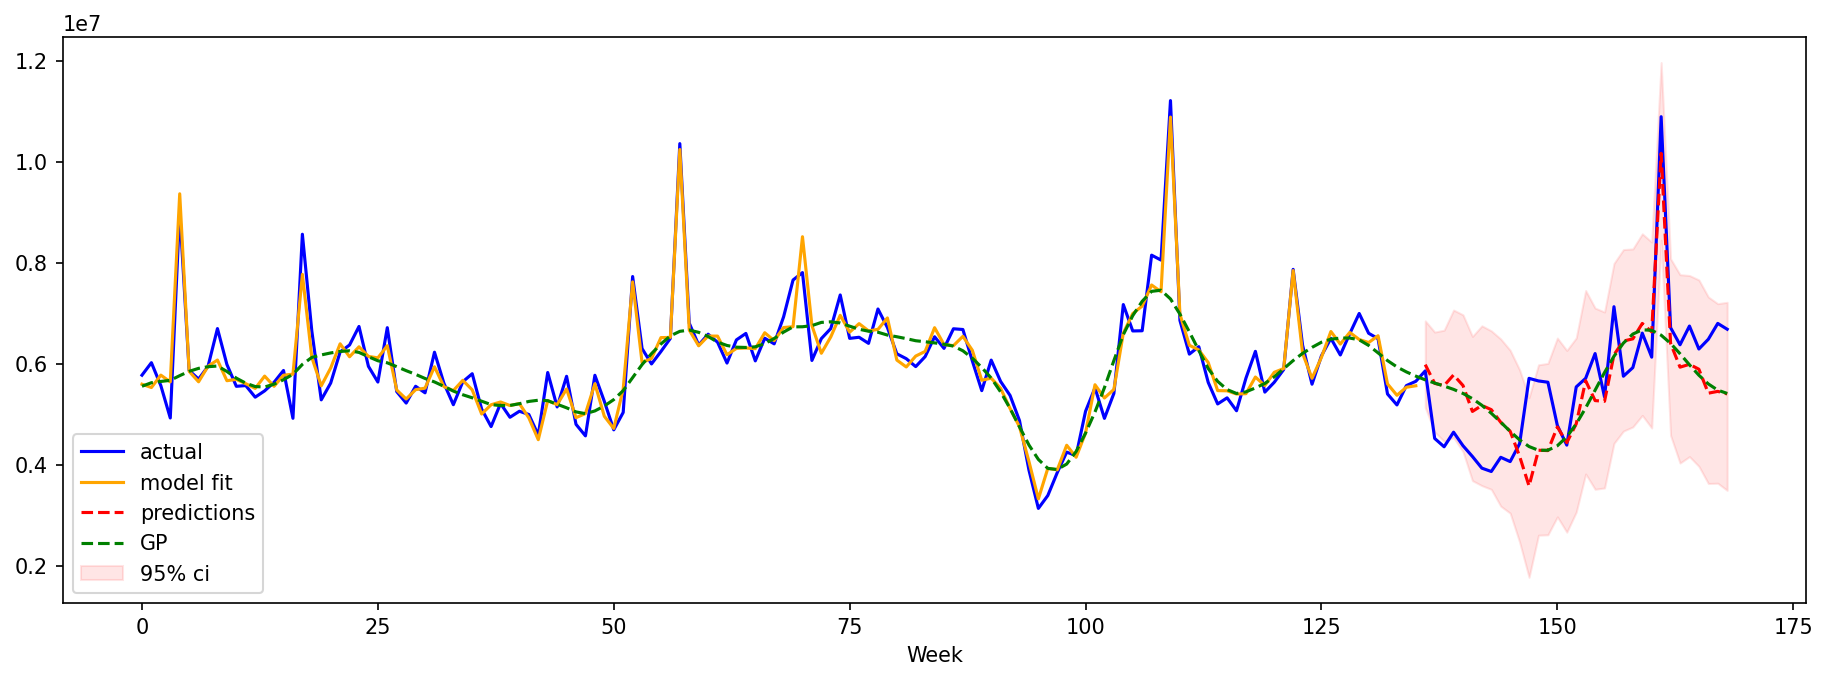

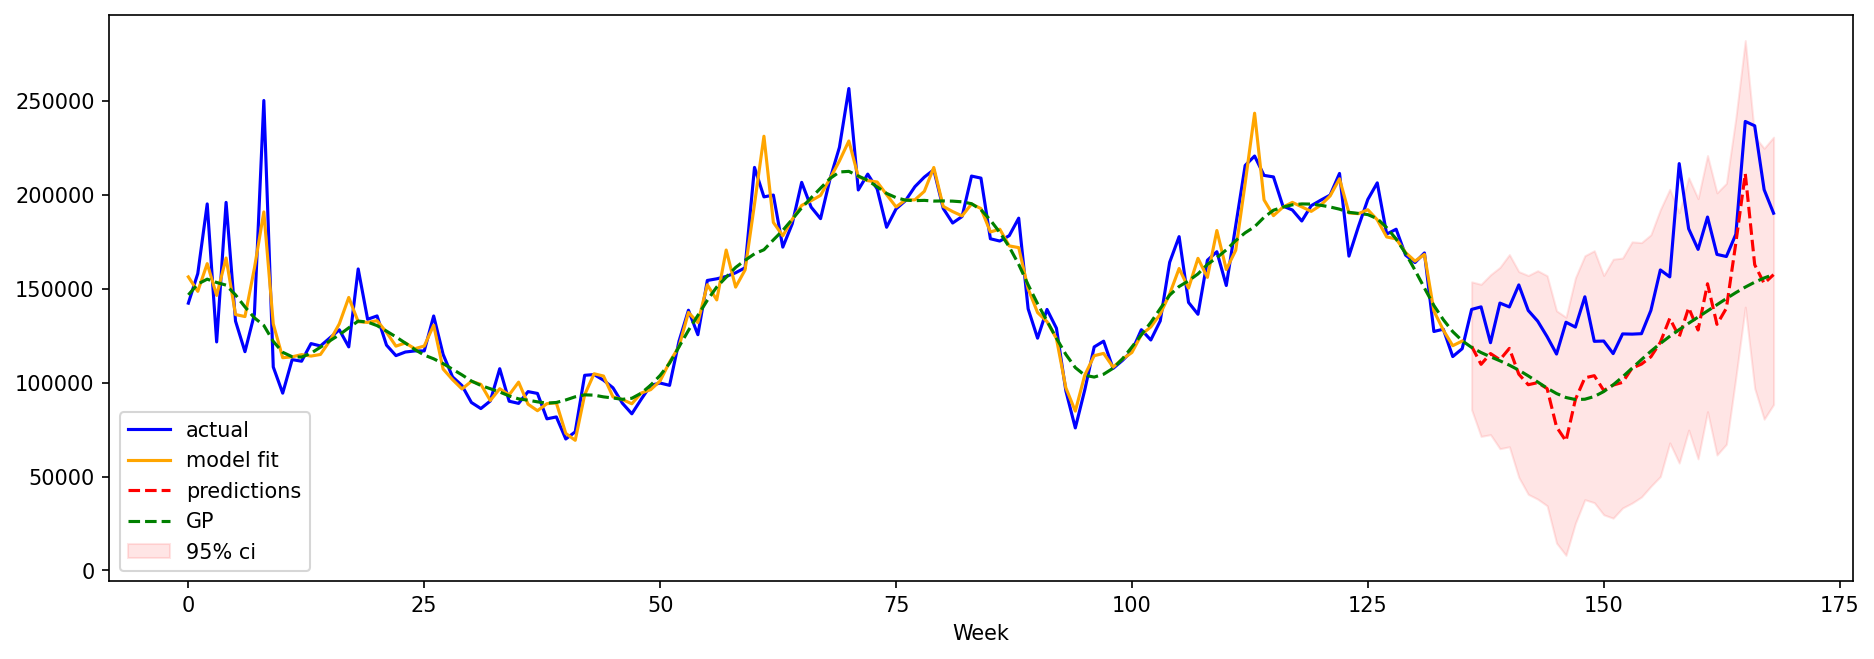

In [15]:
# Plot MAP fit
for i in range(2):
    plot_posterior(Y[:,i], TestLength, map_fit[:,i],map_gp_mean[:,i],MAPci[:,:,i])

### Full Bayesian inference using NUTS
Be warned that the sampling can take several minutes.

In [17]:
Nsamples = 500
NWarmup = 500
Nchains = 4

kernel = NUTS(mv_model, init_strategy=init_to_median(),
              find_heuristic_step_size=True,
             )
mcmc = MCMC(kernel, num_warmup=NWarmup, num_samples=Nsamples, num_chains=Nchains, progress_bar=True)
mcmc.run(random.PRNGKey(1),Yfit,y_obs,weekdays,DT,PERIOD,J,TestLength)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [18]:
# Summary of posterior distributions
mcmc.print_summary()


                       mean       std    median      5.0%     95.0%     n_eff     r_hat
        Lcor[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
        Lcor[0,1]      0.00      0.00      0.00      0.00      0.00       nan       nan
        Lcor[1,0]      0.32      0.21      0.34     -0.01      0.66   1533.20      1.00
        Lcor[1,1]      0.92      0.07      0.94      0.82      1.00   1457.92      1.00
   beta_week[0,0]      0.15      0.34      0.14     -0.38      0.74    630.97      1.00
   beta_week[0,1]      0.18      0.32      0.18     -0.32      0.72    834.22      1.01
   beta_week[1,0]      0.00      0.33      0.01     -0.54      0.56    594.74      1.00
   beta_week[1,1]     -0.13      0.31     -0.12     -0.64      0.41    748.91      1.00
   beta_week[2,0]      0.24      0.35      0.23     -0.32      0.82    584.34      1.00
   beta_week[2,1]      0.16      0.31      0.14     -0.32      0.68    763.35      1.01
   beta_week[3,0]      0.04    

In [19]:
# Get posterior samples
components = mcmc.get_samples()['gp components']
mod_fit = mcmc.get_samples()['model fit']
pred_var = mcmc.get_samples()['pred var']

# smoothed gp component samples
comp_dims = components.shape
components = np.reshape(components, (comp_dims[0],comp_dims[1],2,2))
mu_gp = np.sum(components, axis=3)

# Simulate predictions and compute credible intervals
centile_idx= int(comp_dims[0]*0.025)
pred_simul = dist.MultivariateNormal(mod_fit[:,-TestLength:,:],covariance_matrix=pred_var).rsample(random.PRNGKey(1))
bayes_ci = np.sort(pred_simul*YSTD,axis=0)[[centile_idx,-centile_idx],:,:] + Ymean

# Compute sample means and scale back for plotting
mean_fit = np.mean(mod_fit,axis=0)*YSTD + Ymean
gp_mean = np.mean(mu_gp,axis=0)*YSTD + Ymean
periodic = np.mean(components[:,:,:,1], axis=0)*YSTD + Ymean


### Assess predictions
The rmse for predictions based on posterior means are better than those based on MAP estimates.

In [20]:
# Compute root mean square error for predictions based on posterior mean 
def rmse(predictions,targets):
    return np.linalg.norm(targets - predictions, axis=0) / np.sqrt(len(targets))
rmse(mean_fit[-TestLength:,:],Y[-TestLength:,:])

array([897355.13308885,  28061.77258296])

### Plots of posterior means and credible intervals
Posterior variance seems large, especially for the organic series. 

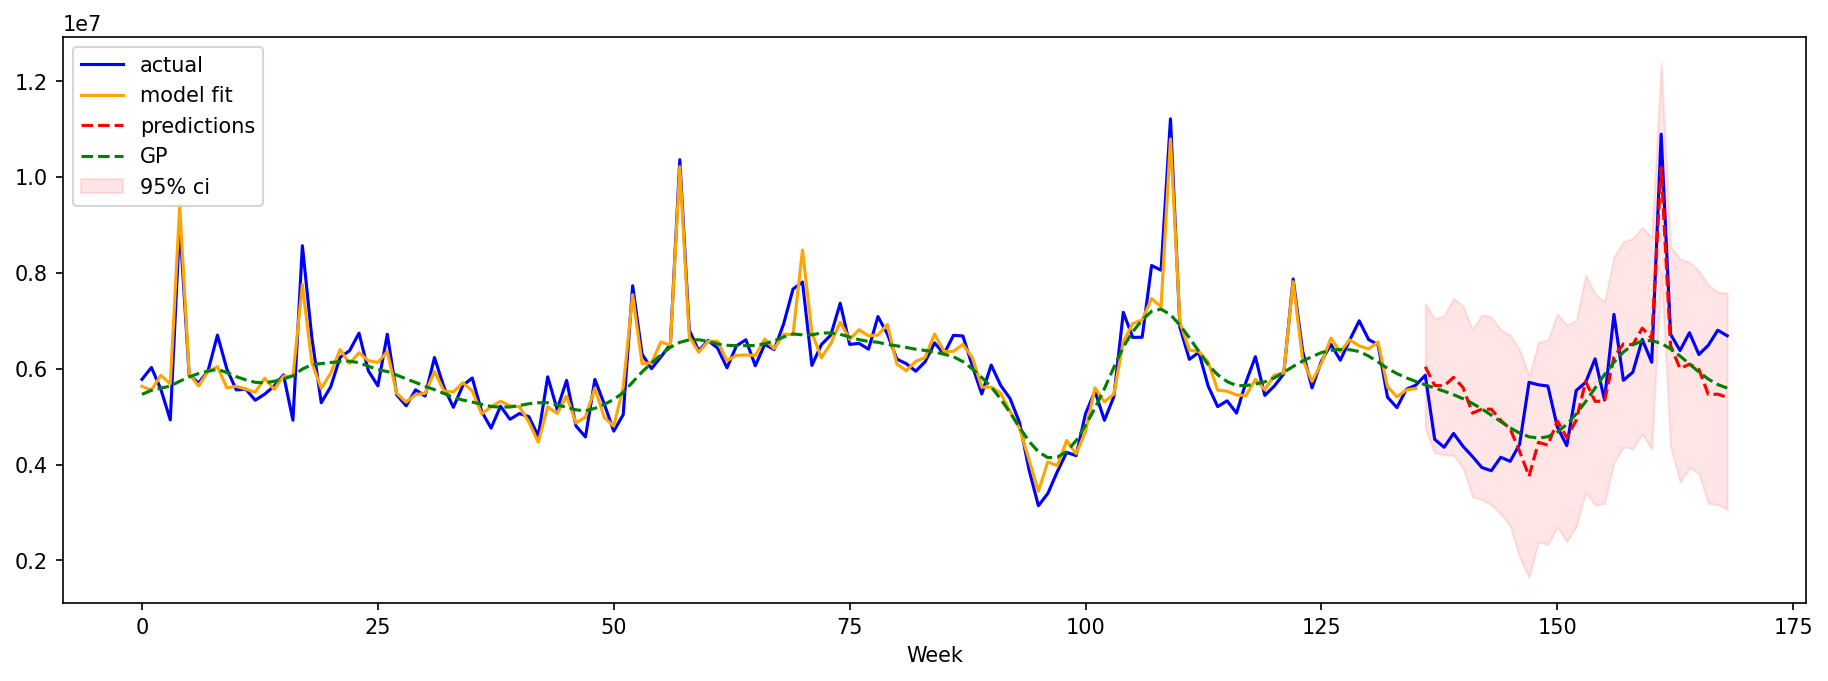

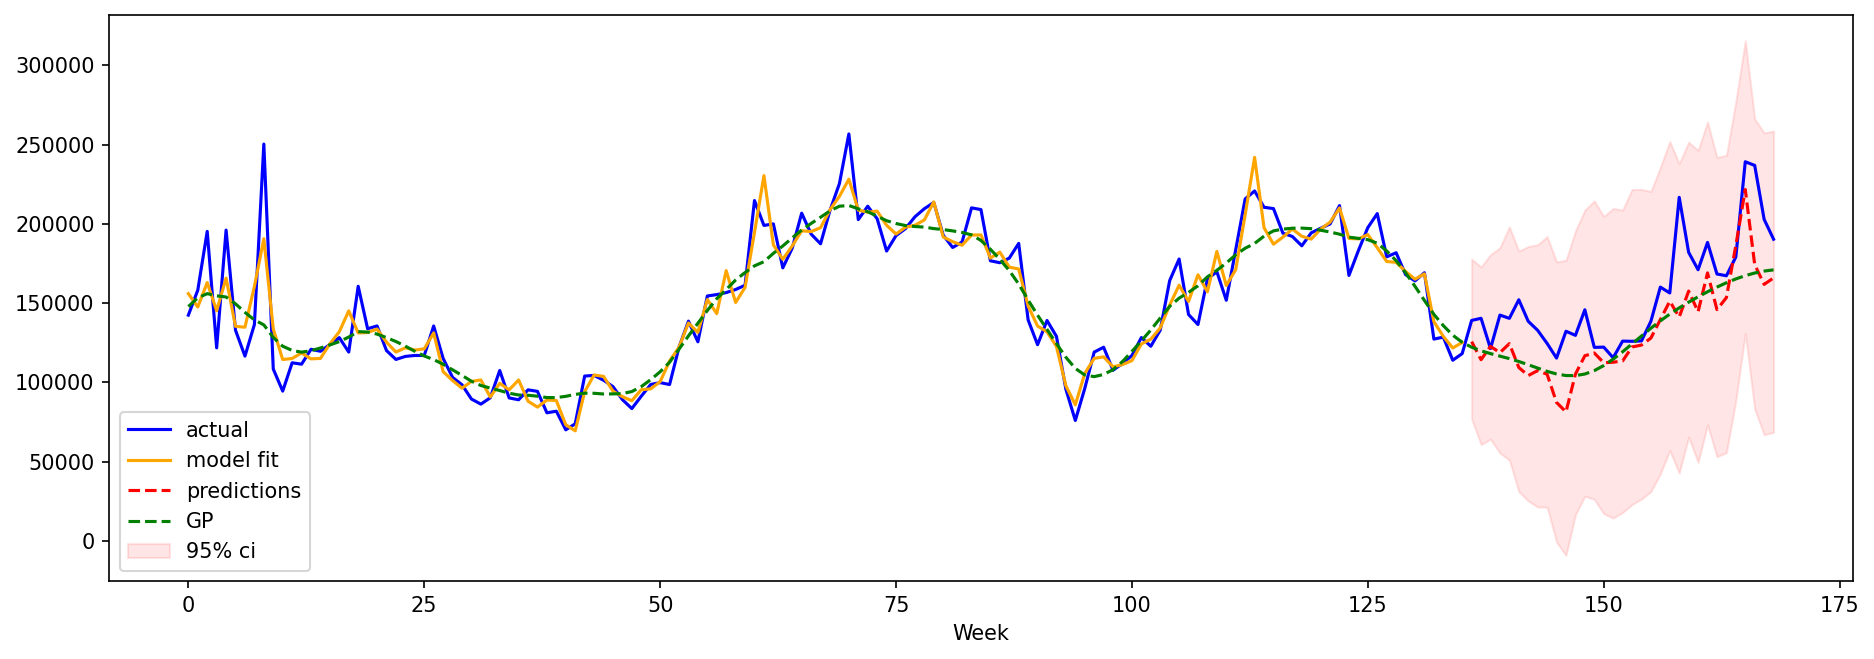

In [21]:
# Plot MCMC fit using posterior means and credible intervals
for i in range(2):
    plot_posterior(Y[:,i], TestLength, mean_fit[:,i],gp_mean[:,i],bayes_ci[:,:,i])